# Gene Ontology Analysis
# Phase 1 vs. Phase 1
using output from [deseq_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb)

following workflow described [here](https://robertslab.github.io/resources/bio-Annotation/) from the Roberts Lab

### 0. load libraries

In [4]:
library(GSEABase)
library(GO.db)
library(tidyverse)

### 1. Map GO IDs to gene IDs

In [5]:
# read in gene ID to GO file
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


## Phase 1 Both vs. Control

In [46]:
# read in DEG file

## BOTH vs. CONTROL
b.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_both_v_cont.csv') %>%
select(X)

colnames(b.c_deg) <- c('gene')
head(b.c_deg)

,gene
,<chr>
1,LOC111119645
2,LOC111111234
3,LOC111104630
4,LOC111100092
5,LOC111129171
6,LOC111121183


In [47]:
b.c_go <- left_join(b.c_deg, gene2go, by = "gene")

colnames(b.c_go) <- c('gene_id', 'Gene.Ontology.IDs')
head(b.c_go)

,gene_id,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111119645,NA
2,LOC111111234,GO:0003677; GO:0003723; GO:0003887; GO:0003964; GO:0004190; GO:0004519; GO:0005634; GO:0005737; GO:0006310; GO:0006508; GO:0015074; GO:0046872
3,LOC111104630,NA
4,LOC111100092,GO:0004674; GO:0005516; GO:0005524; GO:0008344; GO:0018105; GO:0018107; GO:0019901; GO:0031672; GO:0035095; GO:0040017; GO:0045989; GO:0046872; GO:0051782; GO:0060298; GO:0106310
5,LOC111129171,NA
6,LOC111121183,NA


### 2. Map GO IDs to GOslims
code below is taken directly from [Roberts Lab workflow](https://robertslab.github.io/resources/bio-Annotation/)

`input_file` contains DEGs from DESeq analysis - need to update for each comparison

#### 1b. phase 1 both vs. control

In [48]:
# Column names corresponding to gene name/ID and GO IDs
GO.ID.column <- "Gene.Ontology.IDs"
gene.ID.column <- "gene_id"

# Relative path or URL to input file
### BOTH vs. CONTROL
input.file <- b.c_go

##### Official GO info - no need to change #####
goslims_obo <- "goslim_generic.obo"
goslims_url <- "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"


In [49]:
# Find GSEAbase installation location
gseabase_location <- find.package("GSEABase")

# Load path to GOslim OBO file
goslim_obo_destintation <- file.path(gseabase_location, "extdata", goslims_obo, fsep = "/")

# Download the GOslim OBO file
download.file(url = goslims_url, destfile = goslim_obo_destintation)

# Loads package files
gseabase_files <- system.file("extdata", goslims_obo, package="GSEABase")


In [50]:
# read in gene file
#full.gene.df <- read.csv(file = input.file, header = TRUE, sep = ",")
full.gene.df <- b.c_go
str(full.gene.df)

'data.frame':	305 obs. of  2 variables:
 $ gene_id          : chr  "LOC111119645" "LOC111111234" "LOC111104630" "LOC111100092" ...
 $ Gene.Ontology.IDs: chr  NA "GO:0003677; GO:0003723; GO:0003887; GO:0003964; GO:0004190; GO:0004519; GO:0005634; GO:0005737; GO:0006310; GO:"| __truncated__ NA "GO:0004674; GO:0005516; GO:0005524; GO:0008344; GO:0018105; GO:0018107; GO:0019901; GO:0031672; GO:0035095; GO:"| __truncated__ ...


In [51]:
# Clean whitespace, filter NA/empty rows, select columns, and split GO terms using column name variables
gene.GO.df <- full.gene.df %>%
  mutate(!!GO.ID.column := str_replace_all(.data[[GO.ID.column]], "\\s*;\\s*", ";")) %>% # Clean up spaces around ";"
  filter(!is.na(.data[[gene.ID.column]]) & !is.na(.data[[GO.ID.column]]) & .data[[GO.ID.column]] != "") %>% 
  select(all_of(c(gene.ID.column, GO.ID.column)))


str(gene.GO.df)

'data.frame':	127 obs. of  2 variables:
 $ gene_id          : chr  "LOC111111234" "LOC111100092" "LOC111130465" "LOC111136934" ...
 $ Gene.Ontology.IDs: chr  "GO:0003677;GO:0003723;GO:0003887;GO:0003964;GO:0004190;GO:0004519;GO:0005634;GO:0005737;GO:0006310;GO:0006508;G"| __truncated__ "GO:0004674;GO:0005516;GO:0005524;GO:0008344;GO:0018105;GO:0018107;GO:0019901;GO:0031672;GO:0035095;GO:0040017;G"| __truncated__ "GO:0001707;GO:0005783;GO:0005794;GO:0006004;GO:0008417;GO:0010468;GO:0010717;GO:0036065;GO:0036066;GO:0046922;G"| __truncated__ "GO:0000976;GO:0000977;GO:0000978;GO:0000981;GO:0001228;GO:0003309;GO:0003310;GO:0003311;GO:0005634;GO:0006357;G"| __truncated__ ...


In [52]:
# flatten file
flat.gene.GO.df <- gene.GO.df %>% separate_rows(!!sym(GO.ID.column), sep = ";")

str(flat.gene.GO.df)

tibble [1,481 × 2] (S3: tbl_df/tbl/data.frame)
 $ gene_id          : chr [1:1481] "LOC111111234" "LOC111111234" "LOC111111234" "LOC111111234" ...
 $ Gene.Ontology.IDs: chr [1:1481] "GO:0003677" "GO:0003723" "GO:0003887" "GO:0003964" ...


In [53]:
# group genes by GO.ID
grouped.gene.GO.df <- flat.gene.GO.df %>%
  group_by(!!sym(GO.ID.column)) %>%
  summarise(!!gene.ID.column := paste(.data[[gene.ID.column]], collapse = ","))

str(grouped.gene.GO.df)

tibble [900 × 2] (S3: tbl_df/tbl/data.frame)
 $ Gene.Ontology.IDs: chr [1:900] "GO:0000002" "GO:0000016" "GO:0000030" "GO:0000118" ...
 $ gene_id          : chr [1:900] "LOC111100760,LOC111113658" "LOC111136394" "LOC111131556" "LOC111106189" ...


In [54]:
# Vector of GO IDs
go_ids <- grouped.gene.GO.df[[GO.ID.column]]

str(go_ids)

 chr [1:900] "GO:0000002" "GO:0000016" "GO:0000030" "GO:0000118" ...


In [55]:
# create new OBO collection object of just GOslims, based on provided GO IDs
# Create GSEAbase GOCollection using `go_ids`
myCollection <- GOCollection(go_ids)

# Retrieve GOslims from GO OBO file set
slim <- getOBOCollection(gseabase_files)

str(slim)

Formal class 'OBOCollection' [package "GSEABase"] with 7 slots
  ..@ .stanza     :'data.frame':	153 obs. of  1 variable:
  .. ..$ value: chr [1:153] "Root" "Term" "Term" "Term" ...
  ..@ .subset     :'data.frame':	22 obs. of  1 variable:
  .. ..$ value: chr [1:22] "Rhea list of ChEBI terms representing the major species at pH 7.3." "Term not to be used for direct annotation" "Terms planned for obsoletion" "AGR slim" ...
  ..@ .kv         :'data.frame':	2132 obs. of  3 variables:
  .. ..$ stanza_id: chr [1:2132] ".__Root__" ".__Root__" ".__Root__" ".__Root__" ...
  .. ..$ key      : chr [1:2132] "format-version" "data-version" "synonymtypedef" "synonymtypedef" ...
  .. ..$ value    : chr [1:2132] "1.2" "go/releases/2025-10-10/subsets/goslim_generic.owl" "syngo_official_label \"label approved by the SynGO project\"" "systematic_synonym \"Systematic synonym\" EXACT" ...
  ..@ evidenceCode: chr [1:26] "EXP" "IDA" "IPI" "IMP" ...
  ..@ ontology    : chr NA
  ..@ ids         : chr [1:141] "G

In [56]:
# Retrieve Biological Process (BP) GOslims
slimdf <- goSlim(myCollection, slim, "BP", verbose)
str(slimdf)

'data.frame':	72 obs. of  3 variables:
 $ Count  : int  4 2 0 22 6 1 0 0 8 0 ...
 $ Percent: num  0.846 0.423 0 4.651 1.268 ...
 $ Term   : chr  "mitotic cell cycle" "cytokinesis" "cytoplasmic translation" "immune system process" ...


### 2. Perform mapping

In [57]:
# List of GOslims and all GO IDs from `go_ids`
gomap <- as.list(GOBPOFFSPRING[rownames(slimdf)])

# Maps `go_ids` to matching GOslims
mapped <- lapply(gomap, intersect, ids(myCollection))

# Append all mapped GO IDs to `slimdf`
# `sapply` needed to apply paste() to create semi-colon delimited values
slimdf$GO.IDs <- sapply(lapply(gomap, intersect, ids(myCollection)), paste, collapse=";")

# Remove "character(0) string from "GO.IDs" column
slimdf$GO.IDs[slimdf$GO.IDs == "character(0)"] <- ""

# Add self-matching GOIDs to "GO.IDs" column, if not present
for (go_id in go_ids) {
  # Check if the go_id is present in the row names
  if (go_id %in% rownames(slimdf)) {
    # Check if the go_id is not present in the GO.IDs column
    # Also removes white space "trimws()" and converts all to upper case to handle
    # any weird, "invisible" formatting issues.
    if (!go_id %in% trimws(toupper(strsplit(slimdf[go_id, "GO.IDs"], ";")[[1]]))) {
      # Append the go_id to the GO.IDs column with a semi-colon separator
      if (length(slimdf$GO.IDs) > 0 && nchar(slimdf$GO.IDs[nrow(slimdf)]) > 0) {
        slimdf[go_id, "GO.IDs"] <- paste0(slimdf[go_id, "GO.IDs"], "; ", go_id)
      } else {
        slimdf[go_id, "GO.IDs"] <- go_id
      }
    }
  }
}

str(slimdf)

'data.frame':	72 obs. of  4 variables:
 $ Count  : int  4 2 0 22 6 1 0 0 8 0 ...
 $ Percent: num  0.846 0.423 0 4.651 1.268 ...
 $ Term   : chr  "mitotic cell cycle" "cytokinesis" "cytoplasmic translation" "immune system process" ...
 $ GO.IDs : chr  "GO:0000281;GO:1902983;GO:1903469;GO:1990426" "GO:0000281;GO:0032465" "" "GO:0002232;GO:0002407;GO:0002638;GO:0002735;GO:0002753;GO:0006955;GO:0030888;GO:0031295;GO:0034145;GO:0035011;G"| __truncated__ ...


In [58]:
# "Flatten" file so each row is single GO ID with corresponding GOslim
# rownames_to_column needed to retain row name info
slimdf_separated <- as.data.frame(slimdf %>%
  rownames_to_column('GOslim') %>%
  separate_rows(GO.IDs, sep = ";"))

# Group by unique GO ID
grouped_slimdf <- slimdf_separated %>%
  filter(!is.na(GO.IDs) & GO.IDs != "") %>%
  group_by(GO.IDs) %>%
  summarize(GOslim = paste(GOslim, collapse = ";"),
            Term = paste(Term, collapse = ";"))


str(grouped_slimdf)

tibble [354 × 3] (S3: tbl_df/tbl/data.frame)
 $ GO.IDs: chr [1:354] " GO:0002376" " GO:0005975" " GO:0006281" " GO:0006310" ...
 $ GOslim: chr [1:354] "GO:0002376" "GO:0005975" "GO:0006281" "GO:0006310" ...
 $ Term  : chr [1:354] "immune system process" "carbohydrate metabolic process" "DNA repair" "DNA recombination" ...


In [59]:
slimdf.sorted <- slimdf %>% arrange(desc(Count))

b.c.slim.count.df <- slimdf.sorted %>% 
  select(Term, Count)

str(b.c.slim.count.df)

'data.frame':	72 obs. of  2 variables:
 $ Term : chr  "anatomical structure development" "cell differentiation" "signaling" "immune system process" ...
 $ Count: int  107 47 41 22 20 20 17 17 15 12 ...


In [60]:
head(b.c.slim.count.df)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,107
GO:0030154,cell differentiation,47
GO:0023052,signaling,41
GO:0002376,immune system process,22
GO:0055085,transmembrane transport,20
GO:1901135,carbohydrate derivative metabolic process,20


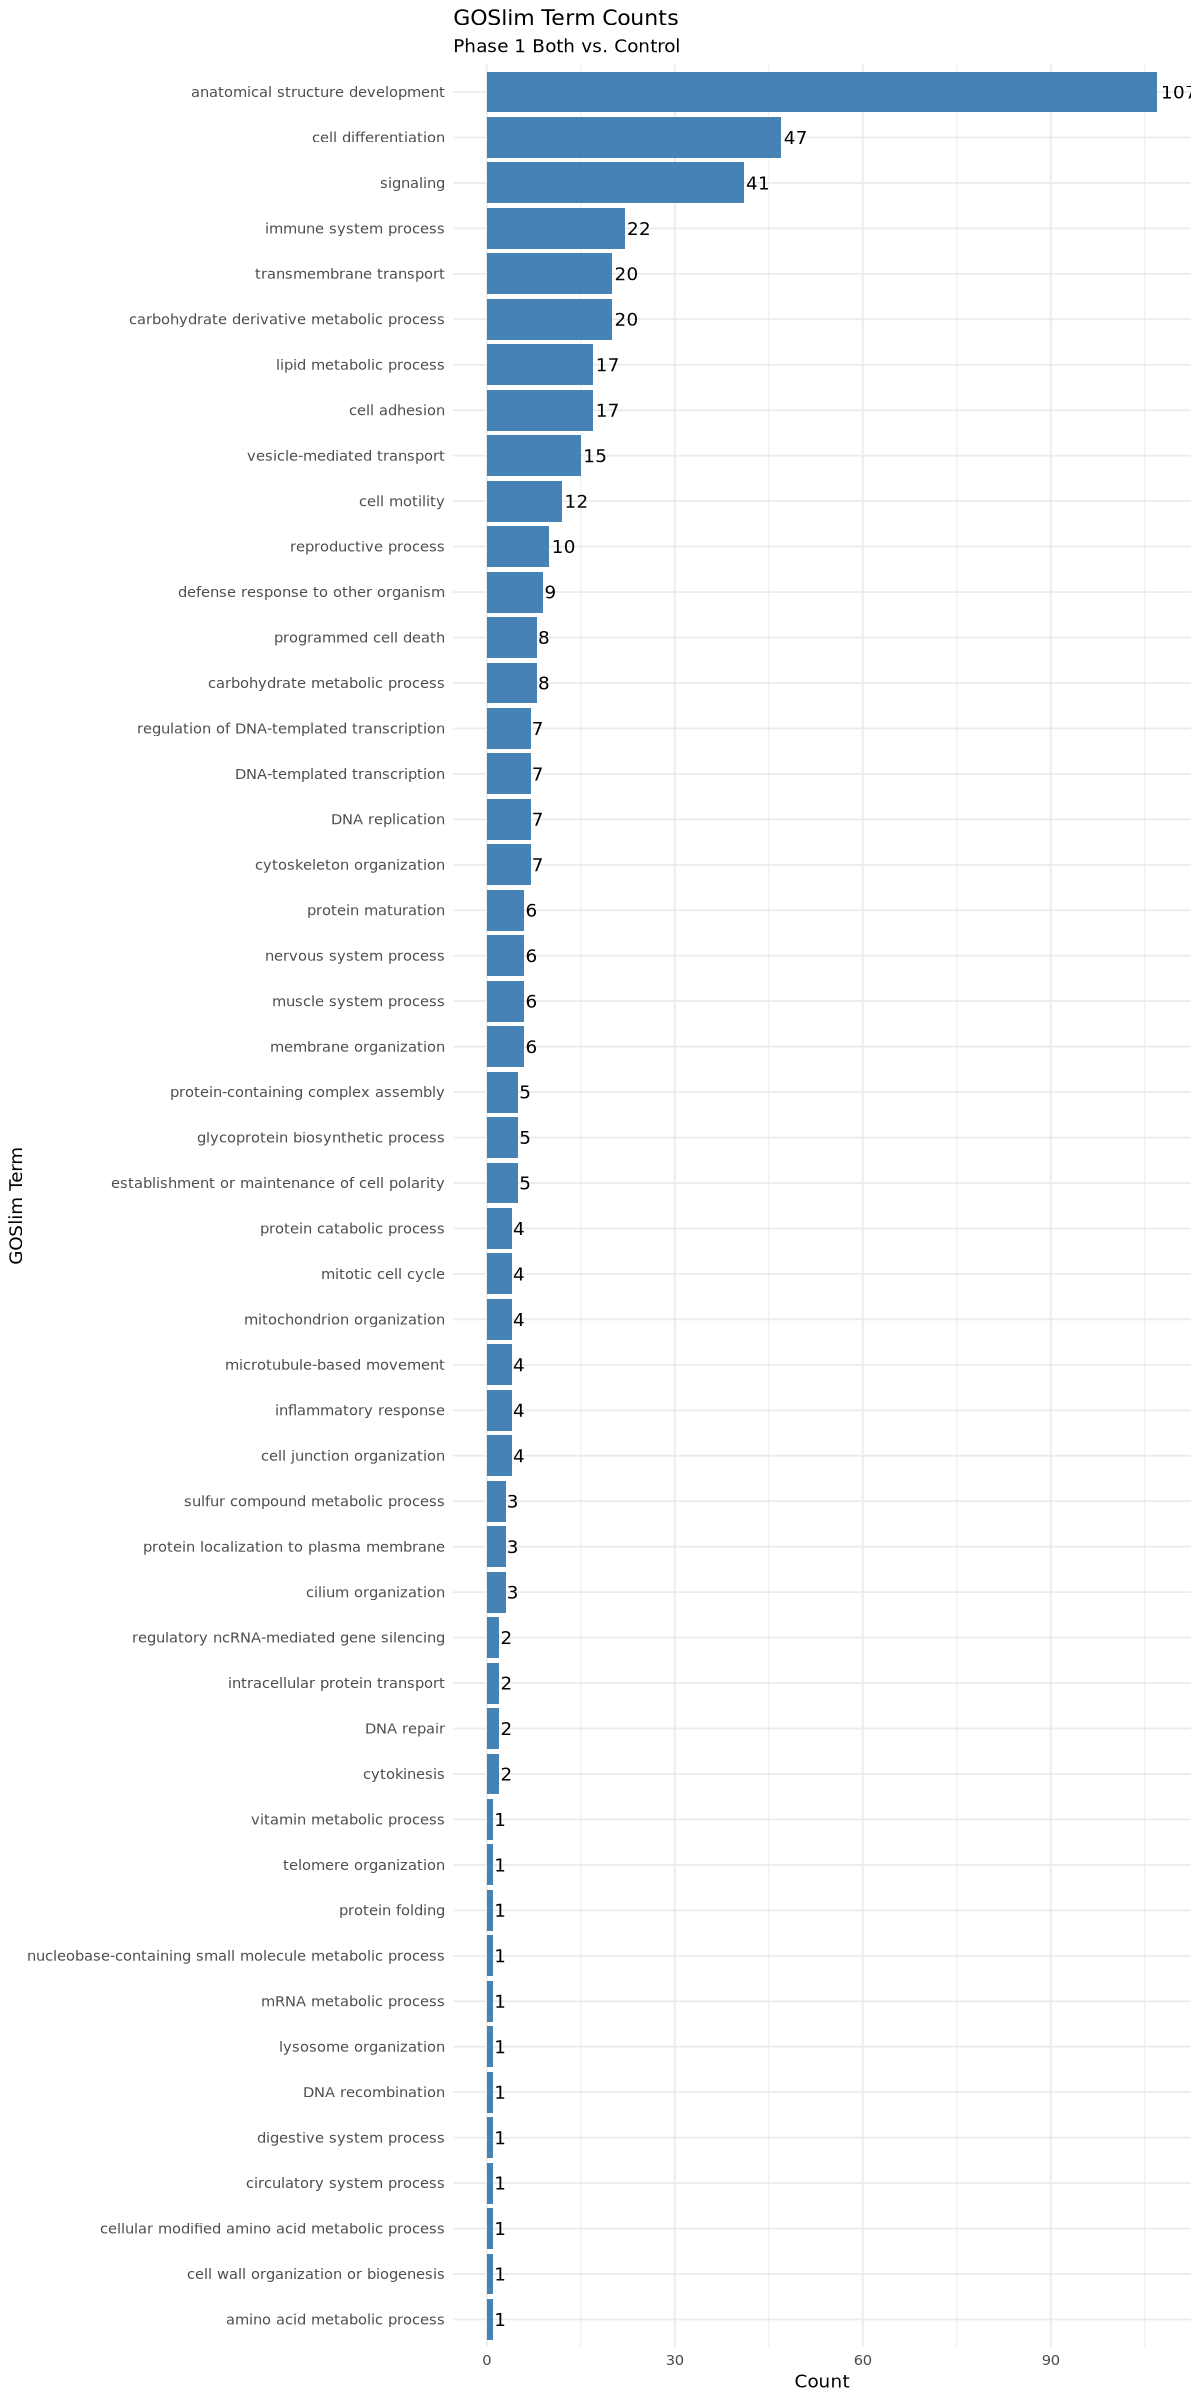

In [61]:
options(repr.plot.width=10, repr.plot.height=20)

b.c.slim.count.df <- b.c.slim.count.df %>%
filter(Count != 0)


b.c_bar <- ggplot(b.c.slim.count.df, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "GOSlim Term Counts",
      subtitle = "Phase 1 Both vs. Control",
    x = "GOSlim Term",
    y = "Count"
  ) +
  theme_minimal()

b.c_bar

## function to reduce code used above for other comparisons

In [6]:
gene2goSlim <- function(gene2go, deg_df) {

    gene_go <- left_join(deg_df, gene2go, by = "gene")

colnames(gene_go) <- c('gene_id', 'Gene.Ontology.IDs')
    
# Column names corresponding to gene name/ID and GO IDs
GO.ID.column <- "Gene.Ontology.IDs"
gene.ID.column <- "gene_id"

# Relative path or URL to input file
### BOTH vs. CONTROL
input.file <- gene_go

##### Official GO info - no need to change #####
goslims_obo <- "goslim_generic.obo"
goslims_url <- "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"

# Find GSEAbase installation location
gseabase_location <- find.package("GSEABase")

# Load path to GOslim OBO file
goslim_obo_destintation <- file.path(gseabase_location, "extdata", goslims_obo, fsep = "/")

# Download the GOslim OBO file
download.file(url = goslims_url, destfile = goslim_obo_destintation)

# Loads package files
gseabase_files <- system.file("extdata", goslims_obo, package="GSEABase")

# read in gene file
#full.gene.df <- read.csv(file = input.file, header = TRUE, sep = ",")
full.gene.df <- gene_go

# Clean whitespace, filter NA/empty rows, select columns, and split GO terms using column name variables
gene.GO.df <- full.gene.df %>%
  mutate(!!GO.ID.column := str_replace_all(.data[[GO.ID.column]], "\\s*;\\s*", ";")) %>% # Clean up spaces around ";"
  filter(!is.na(.data[[gene.ID.column]]) & !is.na(.data[[GO.ID.column]]) & .data[[GO.ID.column]] != "") %>% 
  select(all_of(c(gene.ID.column, GO.ID.column)))

# flatten file
flat.gene.GO.df <- gene.GO.df %>% separate_rows(!!sym(GO.ID.column), sep = ";")

# group genes by GO.ID
grouped.gene.GO.df <- flat.gene.GO.df %>%
  group_by(!!sym(GO.ID.column)) %>%
  summarise(!!gene.ID.column := paste(.data[[gene.ID.column]], collapse = ","))

# Vector of GO IDs
go_ids <- grouped.gene.GO.df[[GO.ID.column]]

# create new OBO collection object of just GOslims, based on provided GO IDs
# Create GSEAbase GOCollection using `go_ids`
myCollection <- GOCollection(go_ids)

# Retrieve GOslims from GO OBO file set
slim <- getOBOCollection(gseabase_files)

# Retrieve Biological Process (BP) GOslims
slimdf <- goSlim(myCollection, slim, "BP", verbose)

# List of GOslims and all GO IDs from `go_ids`
gomap <- as.list(GOBPOFFSPRING[rownames(slimdf)])

# Maps `go_ids` to matching GOslims
mapped <- lapply(gomap, intersect, ids(myCollection))

# Append all mapped GO IDs to `slimdf`
# `sapply` needed to apply paste() to create semi-colon delimited values
slimdf$GO.IDs <- sapply(lapply(gomap, intersect, ids(myCollection)), paste, collapse=";")

# Remove "character(0) string from "GO.IDs" column
slimdf$GO.IDs[slimdf$GO.IDs == "character(0)"] <- ""

# Add self-matching GOIDs to "GO.IDs" column, if not present
for (go_id in go_ids) {
  # Check if the go_id is present in the row names
  if (go_id %in% rownames(slimdf)) {
    # Check if the go_id is not present in the GO.IDs column
    # Also removes white space "trimws()" and converts all to upper case to handle
    # any weird, "invisible" formatting issues.
    if (!go_id %in% trimws(toupper(strsplit(slimdf[go_id, "GO.IDs"], ";")[[1]]))) {
      # Append the go_id to the GO.IDs column with a semi-colon separator
      if (length(slimdf$GO.IDs) > 0 && nchar(slimdf$GO.IDs[nrow(slimdf)]) > 0) {
        slimdf[go_id, "GO.IDs"] <- paste0(slimdf[go_id, "GO.IDs"], "; ", go_id)
      } else {
        slimdf[go_id, "GO.IDs"] <- go_id
      }
    }
  }
}

# "Flatten" file so each row is single GO ID with corresponding GOslim
# rownames_to_column needed to retain row name info
slimdf_separated <- as.data.frame(slimdf %>%
  rownames_to_column('GOslim') %>%
  separate_rows(GO.IDs, sep = ";"))

# Group by unique GO ID
grouped_slimdf <- slimdf_separated %>%
  filter(!is.na(GO.IDs) & GO.IDs != "") %>%
  group_by(GO.IDs) %>%
  summarize(GOslim = paste(GOslim, collapse = ";"),
            Term = paste(Term, collapse = ";"))

slimdf.sorted <- slimdf %>% arrange(desc(Count))

slim.count.df <- slimdf.sorted %>% 
  select(Term, Count)

return(slim.count.df)

    }

## Phase 1 Warm vs. Control

In [12]:
# read in DEG file

## WARM vs. CONTROL
w.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_cont.csv') %>%
select(X)

colnames(w.c_deg) <- c('gene')
head(w.c_deg)

,gene
,<chr>
1,LOC111130870
2,LOC111129171
3,LOC111121183
4,LOC111106303
5,LOC111122541
6,LOC111130453


In [10]:
w.c_goSlim <- gene2goSlim(gene2go,w.c_deg)
head(w.c_goSlim)

,Term,Count
,<chr>,<int>
GO:0002376,immune system process,19
GO:0023052,signaling,17
GO:0016192,vesicle-mediated transport,12
GO:0098542,defense response to other organism,12
GO:0048856,anatomical structure development,11
GO:0032200,telomere organization,10


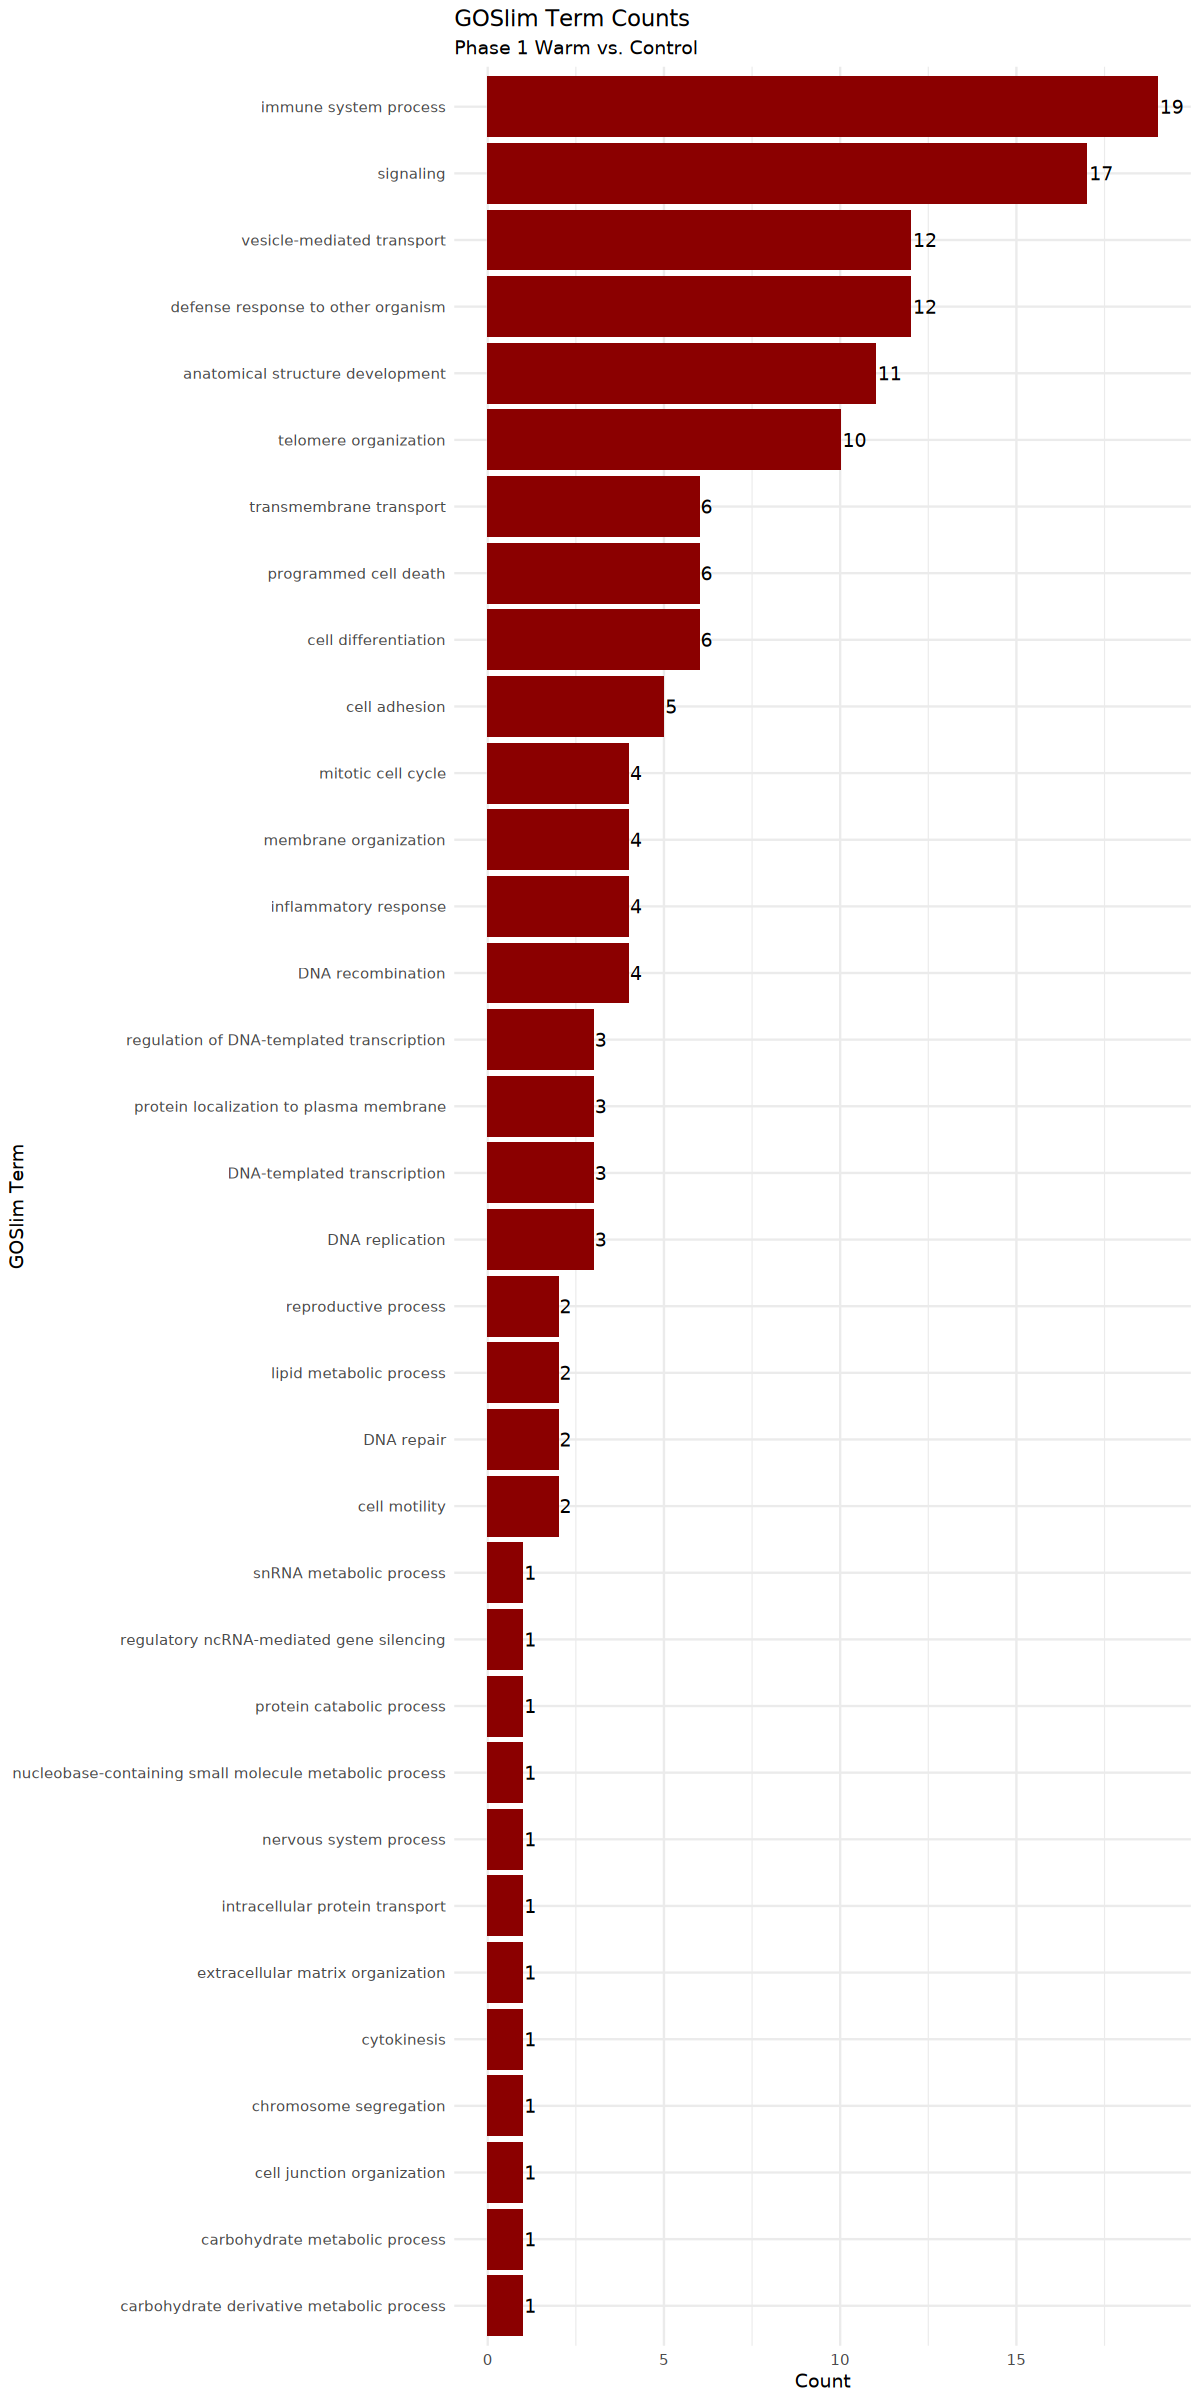

In [11]:
options(repr.plot.width=10, repr.plot.height=20)

w.c_goSlim <- w.c_goSlim %>%
filter(Count != 0)

w.c_bar <- ggplot(w.c_goSlim, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "red4") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "GOSlim Term Counts",
      subtitle = "Phase 1 Warm vs. Control",
    x = "GOSlim Term",
    y = "Count"
  ) +
  theme_minimal()

w.c_bar

## Phase 1 Hypoxic vs. Control

In [14]:
# read in DEG file

## HYPOXIC vs. CONTROL
h.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_hyp_v_cont.csv') %>%
select(X)

colnames(h.c_deg) <- c('gene')
head(h.c_deg)

,gene
,<chr>
1,LOC111121183
2,LOC111120021
3,LOC111119724
4,LOC111119726
5,LOC111121216
6,LOC111125414


In [15]:
h.c_goSlim <- gene2goSlim(gene2go, h.c_deg)
head(h.c_goSlim)

,Term,Count
,<chr>,<int>
GO:0016192,vesicle-mediated transport,6
GO:0055085,transmembrane transport,5
GO:0030154,cell differentiation,4
GO:0048856,anatomical structure development,4
GO:0061024,membrane organization,3
GO:0072659,protein localization to plasma membrane,3


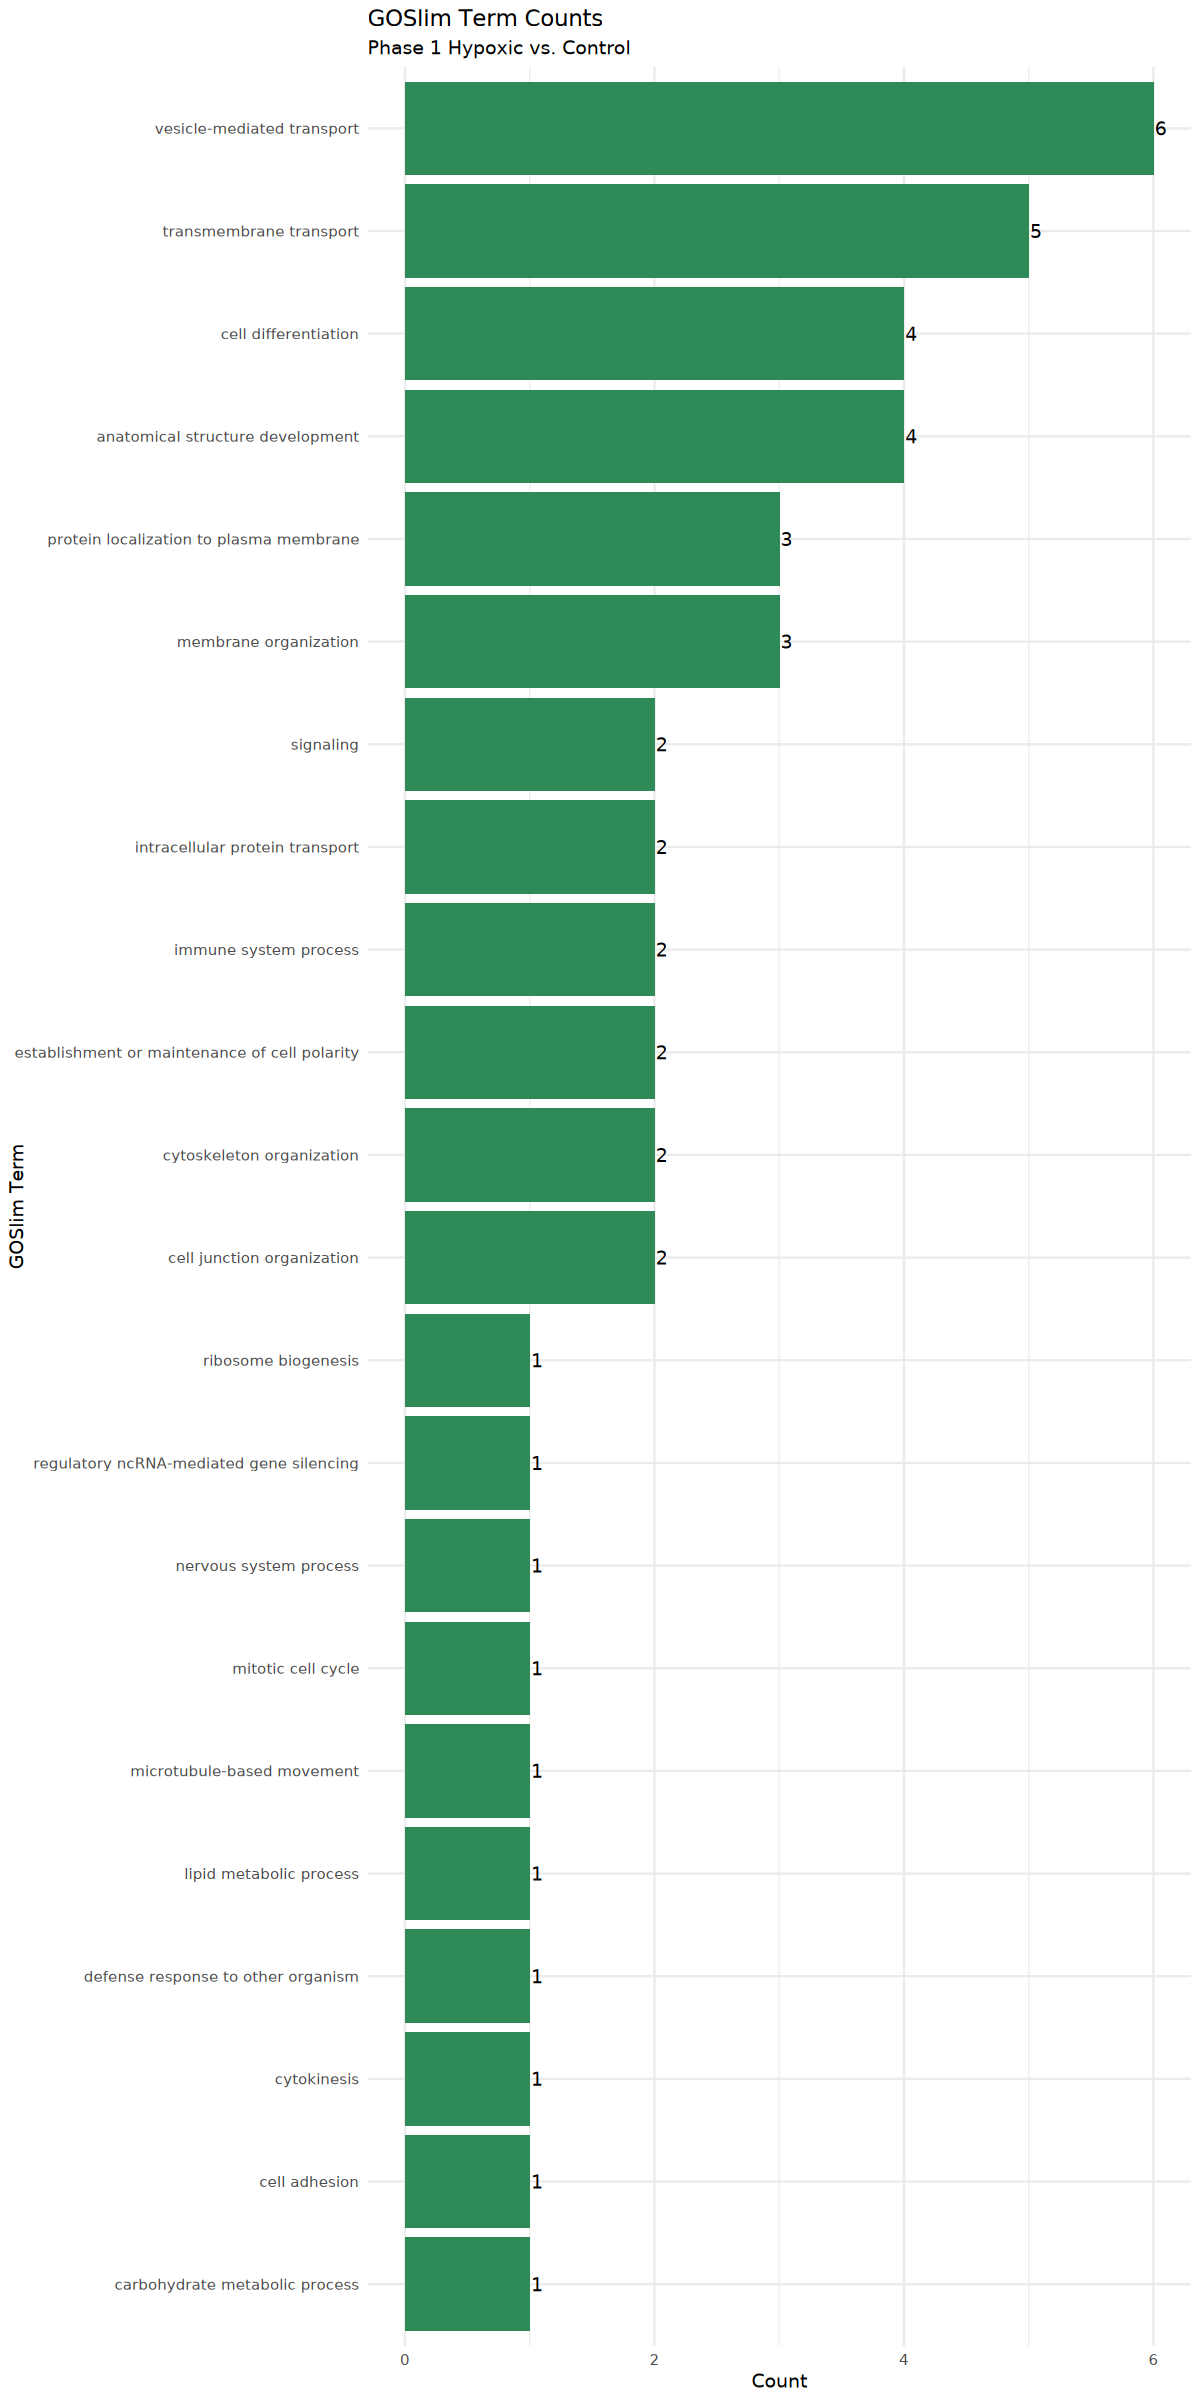

In [16]:
options(repr.plot.width=10, repr.plot.height=20)

h.c_goSlim <- h.c_goSlim %>%
filter(Count != 0)


h.c_bar <- ggplot(h.c_goSlim, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "seagreen4") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "GOSlim Term Counts",
      subtitle = "Phase 1 Hypoxic vs. Control",
    x = "GOSlim Term",
    y = "Count"
  ) +
  theme_minimal()

h.c_bar

## comparisons outside those with control
## Phase 1 Warm vs. Hypoxic

In [17]:
# read in DEG file

## WARM vs. HYPOXIC
w.h_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_hyp.csv') %>%
select(X)

colnames(w.h_deg) <- c('gene')
head(w.h_deg)

,gene
,<chr>
1,LOC111112448
2,LOC111113921
3,LOC111110198
4,LOC111129171
5,LOC111103459
6,LOC111135260


In [18]:
w.h_goSlim <- gene2goSlim(gene2go, w.h_deg)
head(w.h_goSlim)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,15
GO:0023052,signaling,11
GO:0006629,lipid metabolic process,9
GO:0016192,vesicle-mediated transport,9
GO:0030154,cell differentiation,8
GO:0002376,immune system process,7


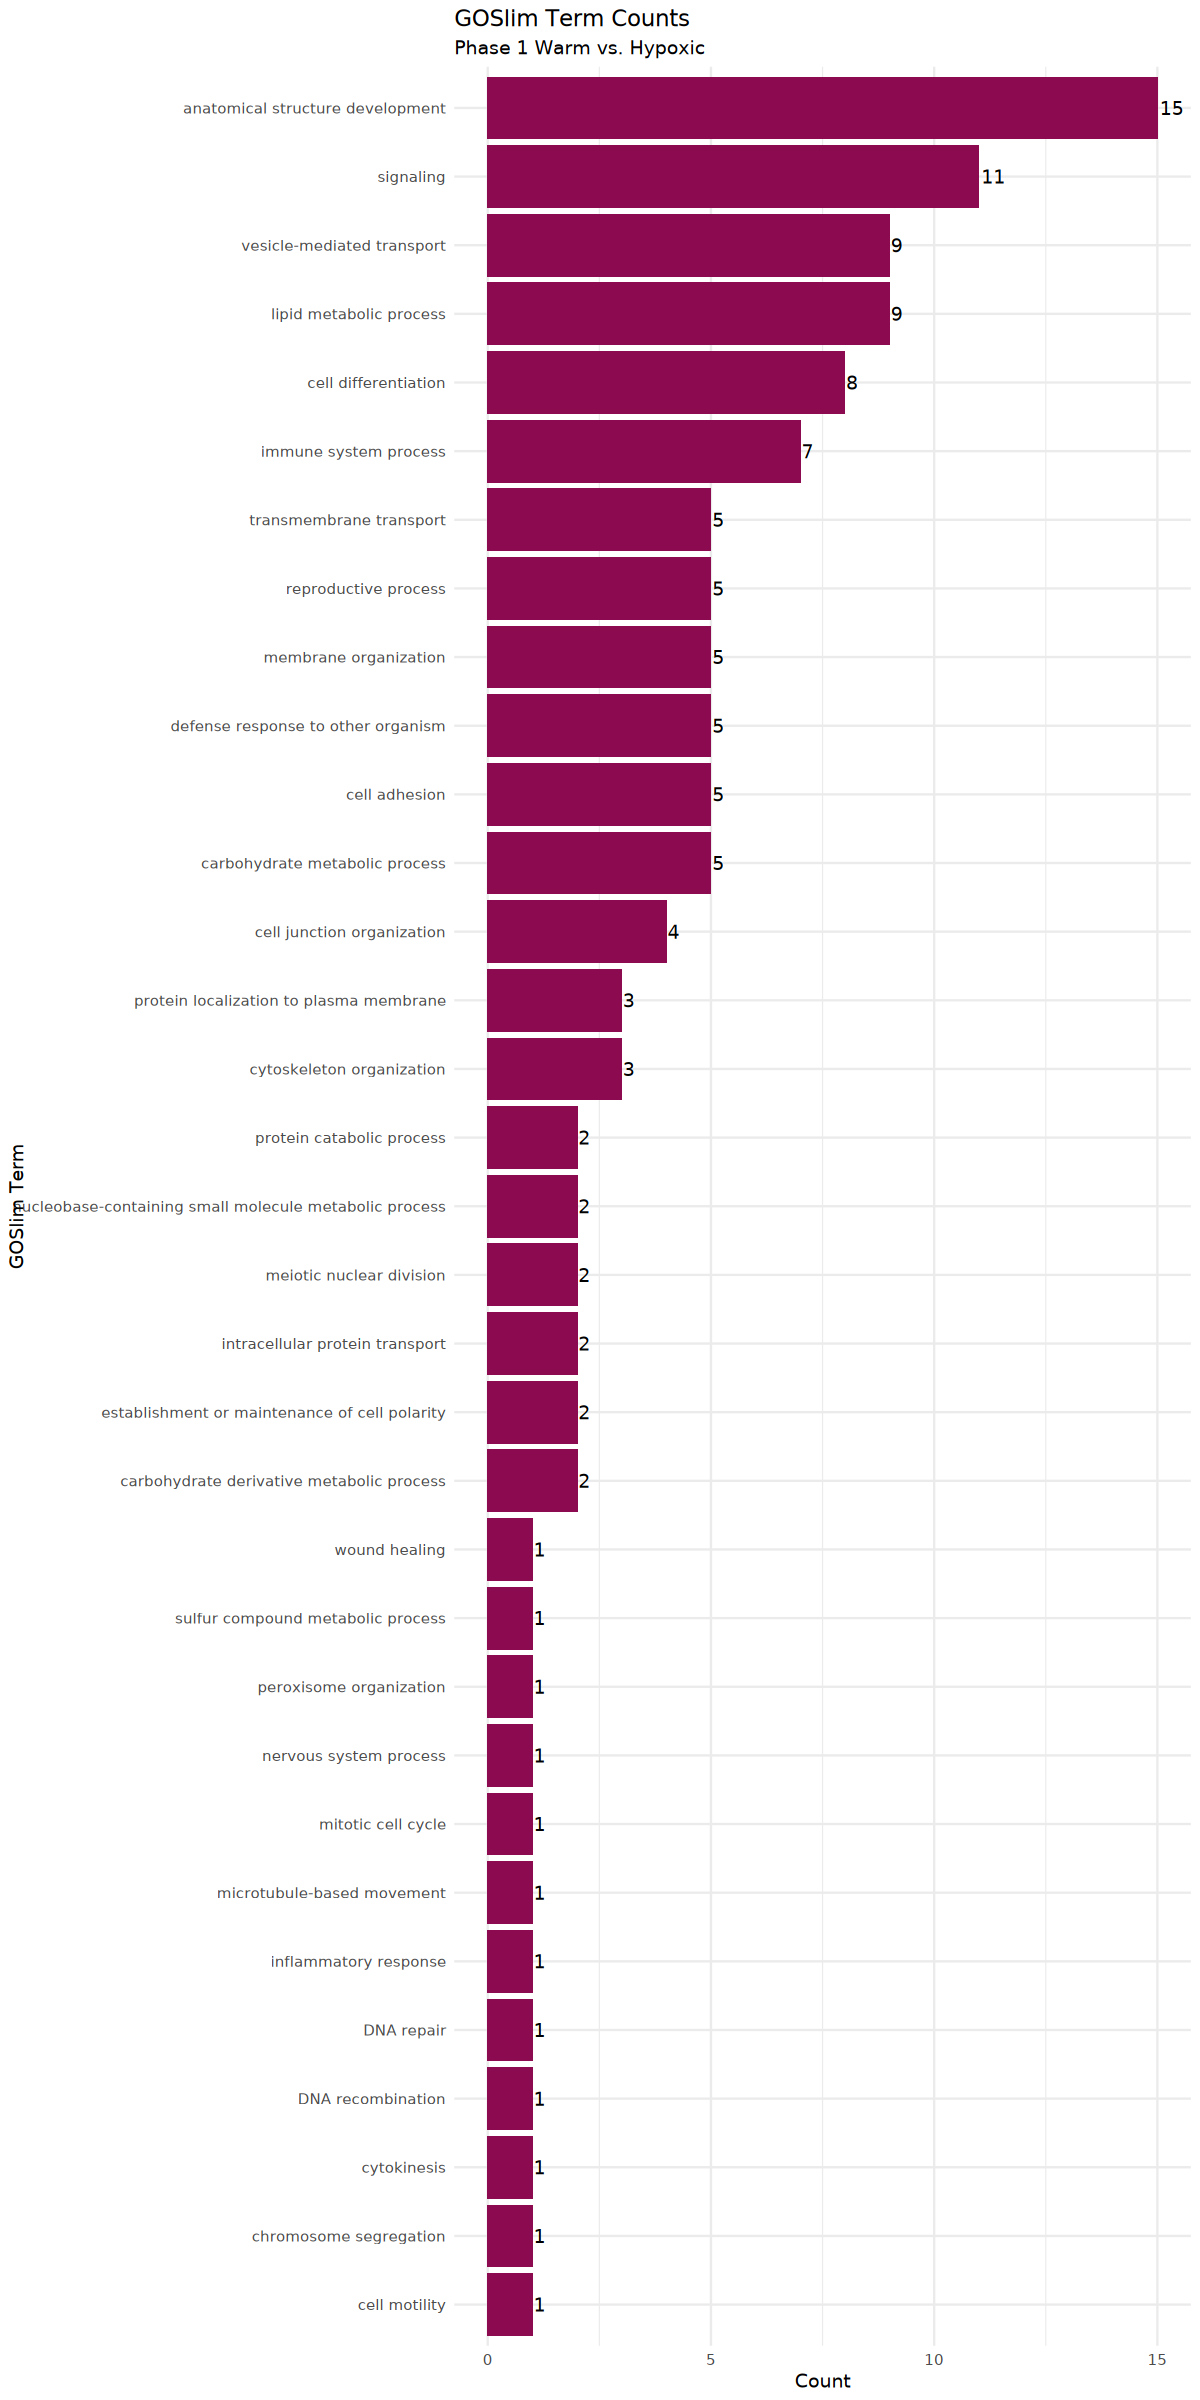

In [19]:
options(repr.plot.width=10, repr.plot.height=20)

w.h_goSlim <- w.h_goSlim %>%
filter(Count != 0)

w.h_bar <- ggplot(w.h_goSlim, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "deeppink4") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "GOSlim Term Counts",
      subtitle = "Phase 1 Warm vs. Hypoxic",
    x = "GOSlim Term",
    y = "Count"
  ) +
  theme_minimal()

w.h_bar

## Phase 1 Warm vs. Both

In [20]:
# read in DEG file

## WARM vs. BOTH
w.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_both.csv') %>%
select(X)

colnames(w.b_deg) <- c('gene')
head(w.b_deg)

,gene
,<chr>
1,LOC111119645
2,LOC111106320
3,LOC111115327
4,LOC111102200
5,LOC111105368
6,LOC111134528


In [21]:
w.b_goSlim <- gene2goSlim(gene2go, w.b_deg)
head(w.b_goSlim)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,70
GO:0030154,cell differentiation,29
GO:0023052,signaling,23
GO:0006629,lipid metabolic process,15
GO:0002376,immune system process,12
GO:0007155,cell adhesion,12


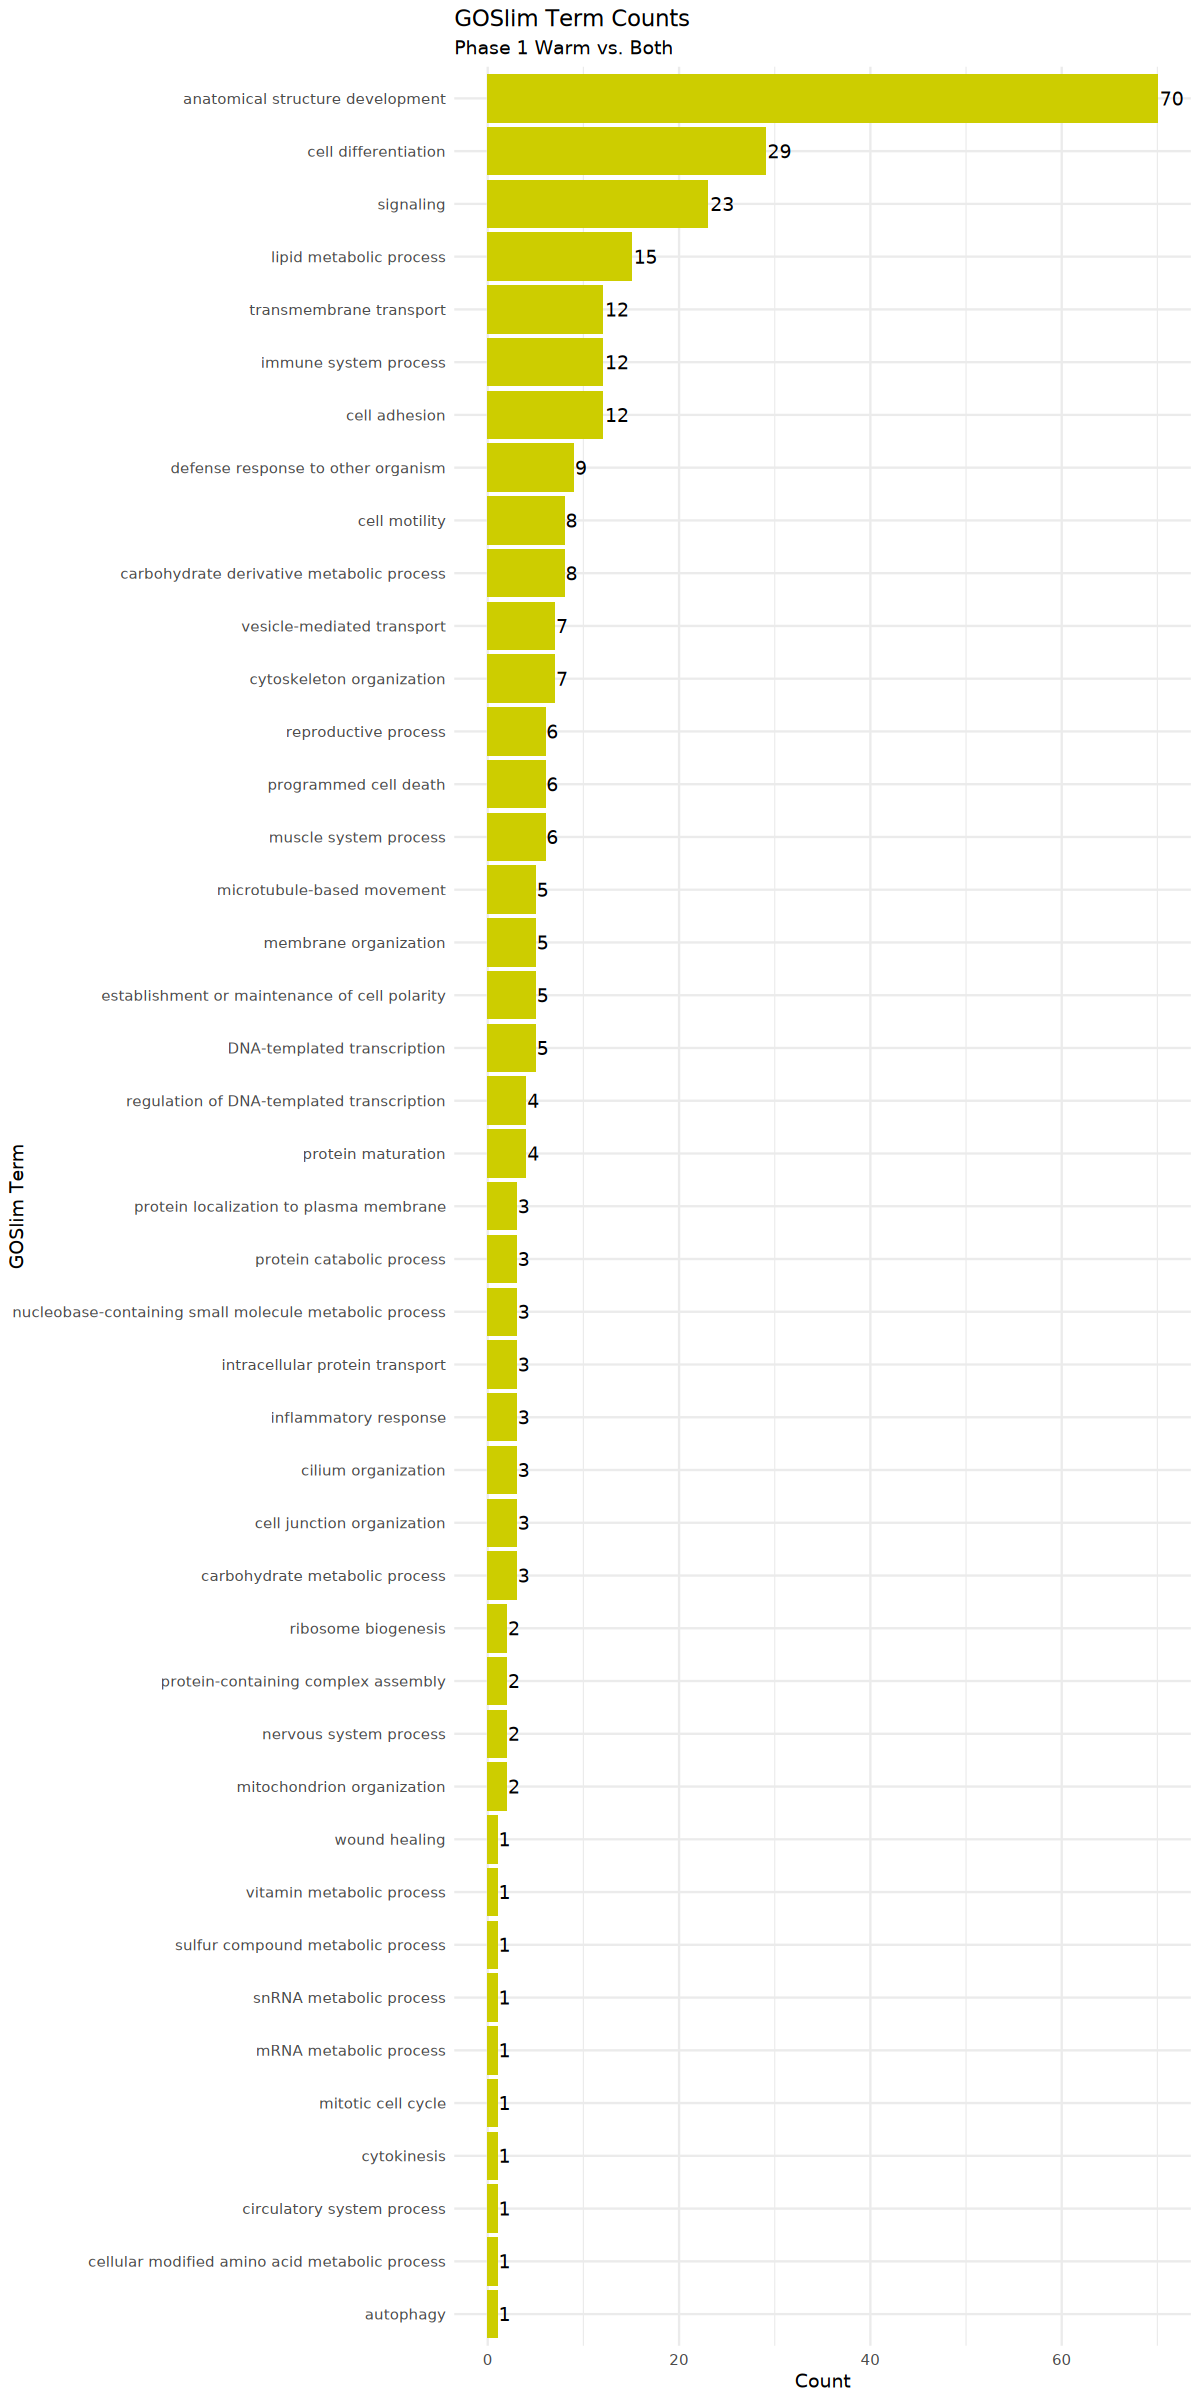

In [22]:
options(repr.plot.width=10, repr.plot.height=20)

w.b_goSlim <- w.b_goSlim %>%
filter(Count != 0)

w.b_bar <- ggplot(w.b_goSlim, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "yellow3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "GOSlim Term Counts",
      subtitle = "Phase 1 Warm vs. Both",
    x = "GOSlim Term",
    y = "Count"
  ) +
  theme_minimal()

w.b_bar

## Phase 1 Hypoxic vs. Both

In [23]:
# read in DEG file

## BOTH vs. CONTROL
h.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_hyp_v_both.csv') %>%
select(X)

colnames(h.b_deg) <- c('gene')
head(h.b_deg)

,gene
,<chr>
1,LOC111119645
2,LOC111103382
3,LOC111104182
4,LOC111129171
5,LOC111111721
6,LOC111111747


In [24]:
h.b_goSlim <- gene2goSlim(gene2go, h.b_deg)
head(h.b_goSlim)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,59
GO:0030154,cell differentiation,27
GO:0023052,signaling,18
GO:0055085,transmembrane transport,16
GO:0007155,cell adhesion,13
GO:0002376,immune system process,11


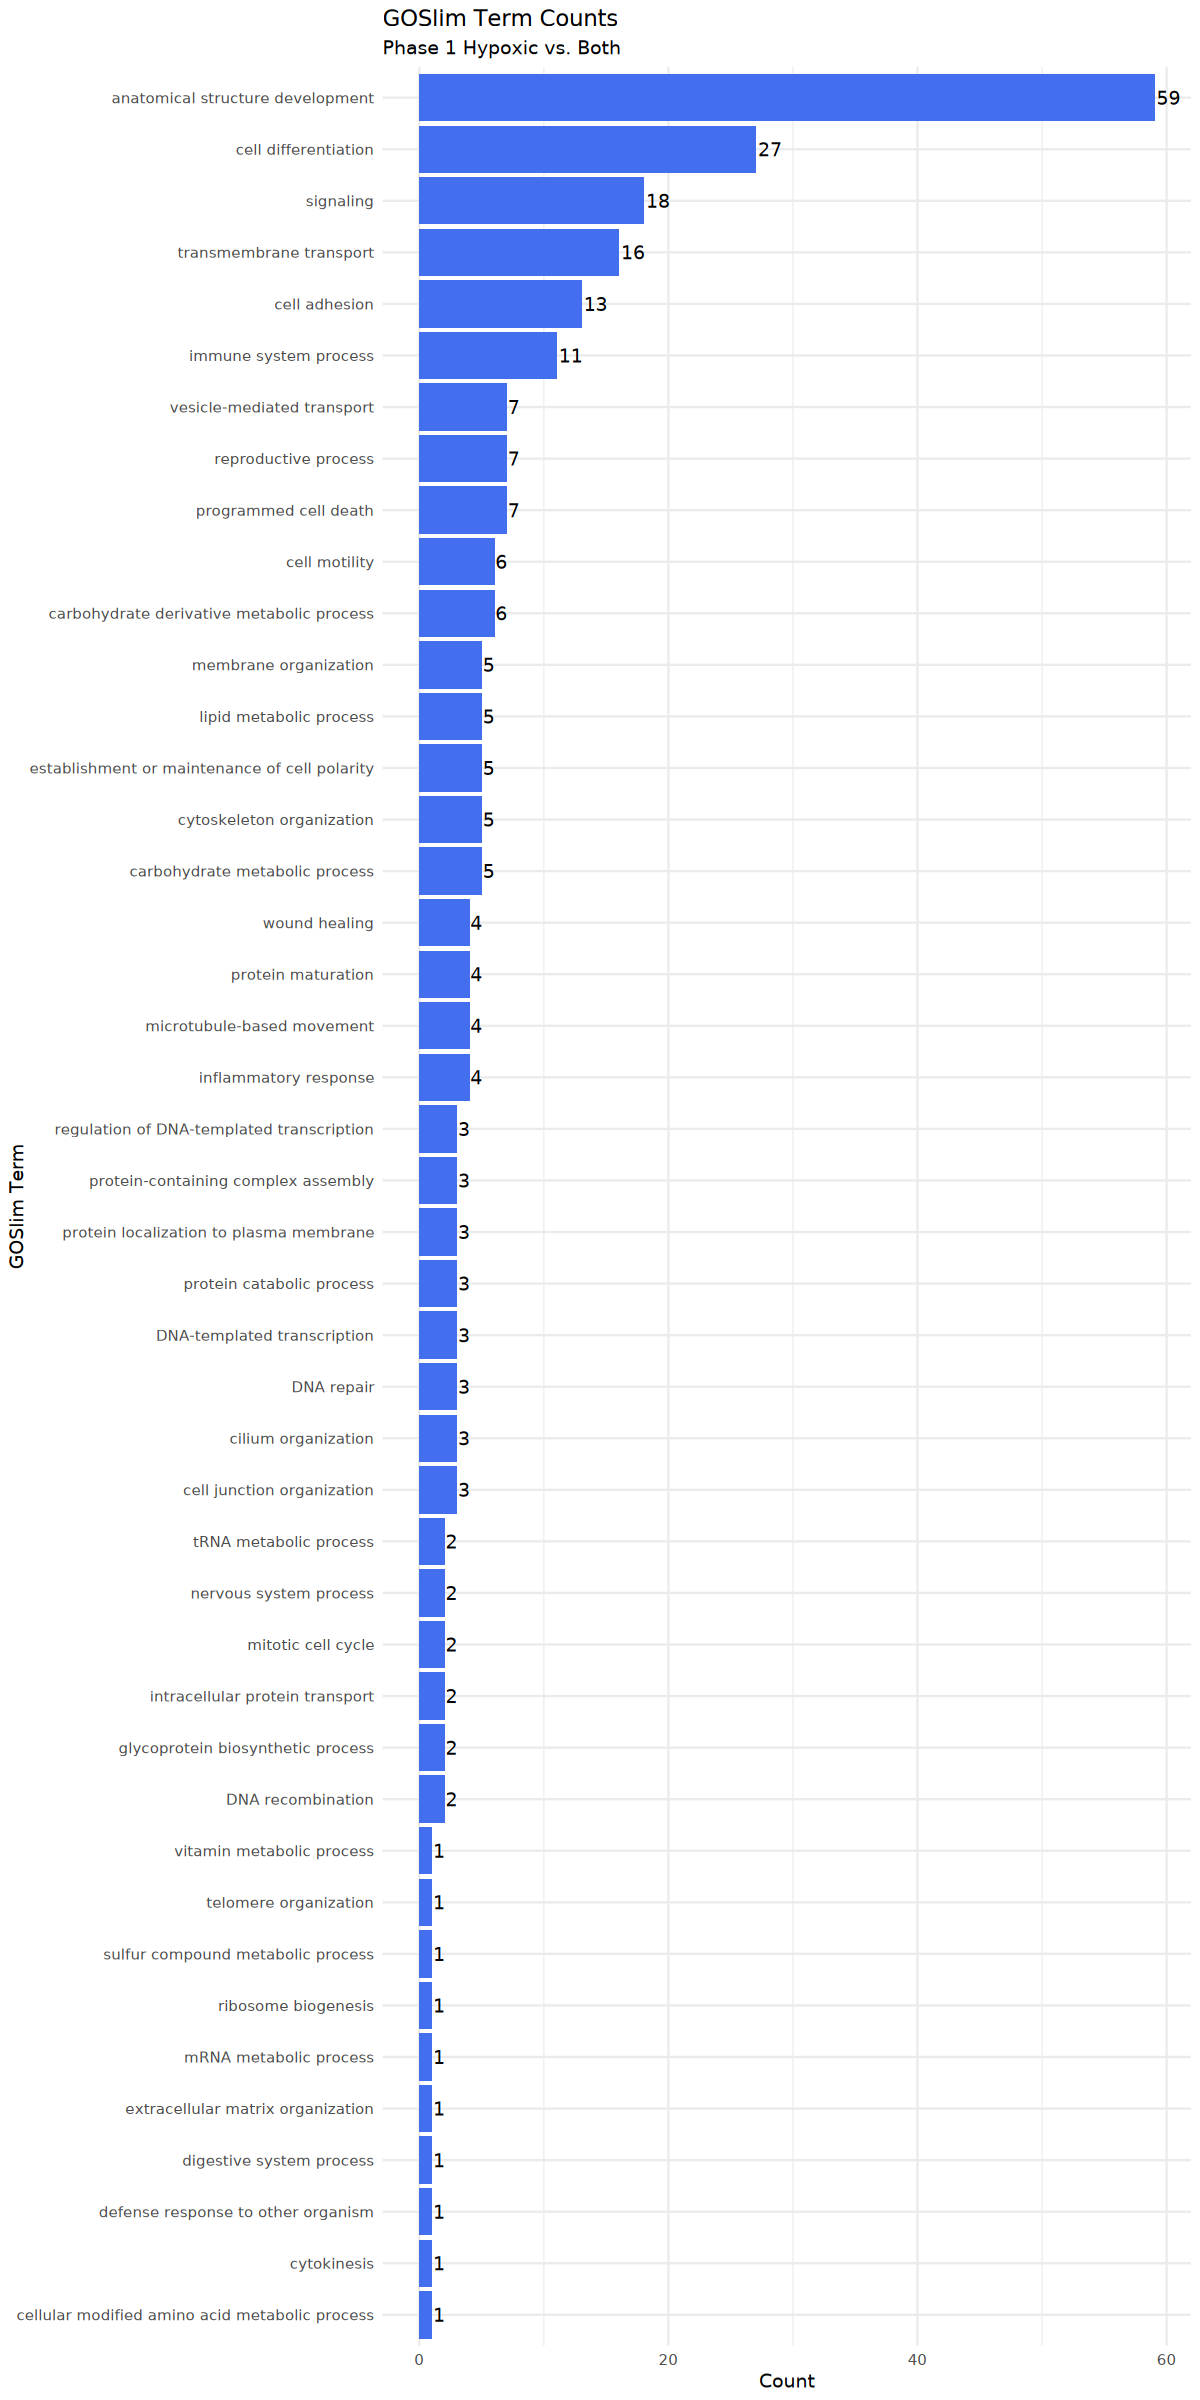

In [26]:
options(repr.plot.width=10, repr.plot.height=20)

h.b_goSlim <- h.b_goSlim %>%
filter(Count != 0)


h.b_bar <- ggplot(h.b_goSlim, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "royalblue2") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "GOSlim Term Counts",
      subtitle = "Phase 1 Hypoxic vs. Both",
    x = "GOSlim Term",
    y = "Count"
  ) +
  theme_minimal()

h.b_bar